# Classification. Linear models and KNN

In [236]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [237]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [238]:
PATH = "./data/"

In [239]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [240]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [241]:
## your code
males = data[data.Sex == 'male'].Sex.count()
females = data[data.Sex == 'female'].Sex.count()
males_survived = data[(data.Sex == 'male') & (data.Survived == 1)].Sex.count()
females_survived = data[(data.Sex == 'female') & (data.Survived == 1)].Sex.count()
print('males_survived', males_survived / males * 100, '%')
print('females_survived', females_survived / females * 100, '%')

males_survived 18.890814558058924 %
females_survived 74.20382165605095 %


ВЫВОД.
Вероятно, старались спасать женщин в первую очередь

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

Text(45, 30, 'Average age: 30.6 , median age: 28.0')

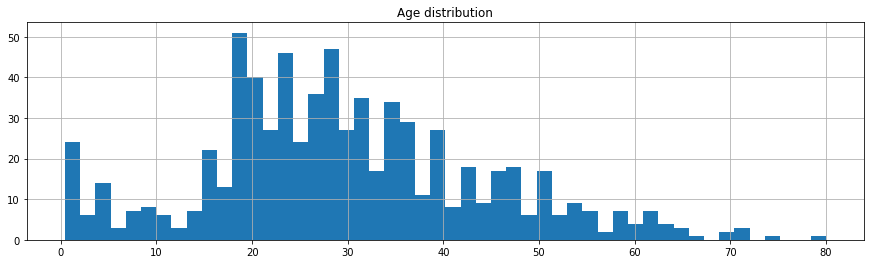

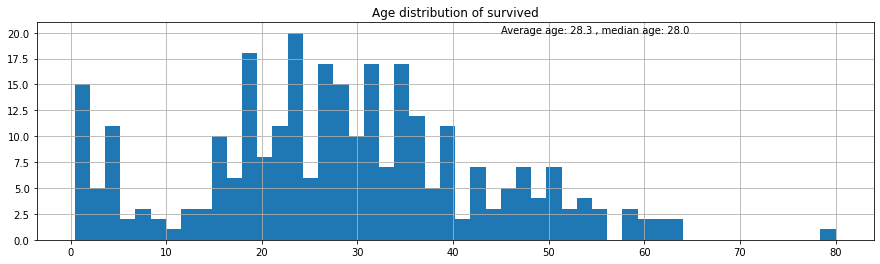

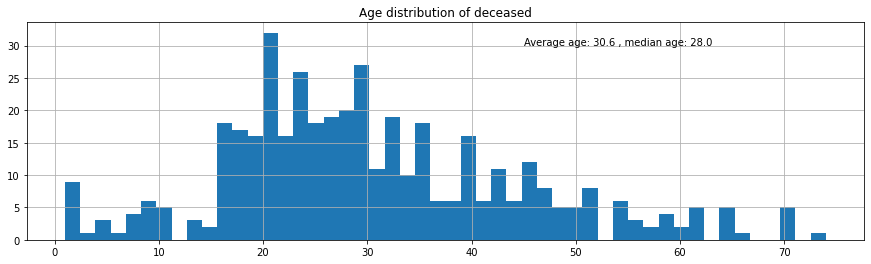

In [242]:
## your code
data_age_dropped = data.copy(deep=True)
data_age_dropped = data_age_dropped.dropna(subset=['Age'])
data_age_dropped.hist(column='Age', bins=50, figsize=(15, 4))
plt.title('Age distribution')
data_age_dropped[data_age_dropped.Survived == 1].hist(column='Age', bins=50, figsize=(15, 4))
plt.title('Age distribution of survived')
plt.text(45, 20, f'Average age: {round(data_age_dropped[data_age_dropped.Survived == 1].Age.mean(), 1)} , median age: {data_age_dropped[data_age_dropped.Survived == 1].Age.median()}')
data_age_dropped[data_age_dropped.Survived == 0].hist(column='Age', bins=50, figsize=(15, 4))
plt.title('Age distribution of deceased')
plt.text(45, 30, f'Average age: {round(data_age_dropped[data_age_dropped.Survived == 0].Age.mean(), 1)} , median age: {data_age_dropped[data_age_dropped.Survived == 0].Age.median()}')

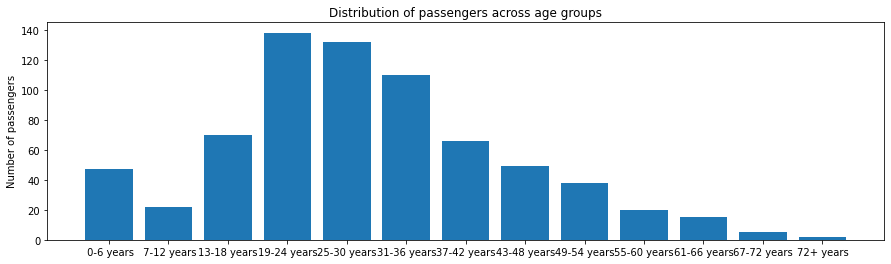

In [243]:
data_age_dropped['age_group'] = data_age_dropped.apply(lambda x: ' 0-6 years' if x['Age'] <= 6 else ' 7-12 years' if x['Age'] <= 12\
                               else '13-18 years' if x['Age'] <= 18 else '19-24 years' if x['Age'] <= 24\
                               else '25-30 years' if x['Age'] <= 30 else '31-36 years' if x['Age'] <= 36\
                               else '37-42 years' if x['Age'] <= 42 else '43-48 years' if x['Age'] <= 48\
                               else '49-54 years' if x['Age'] <= 54 else '55-60 years' if x['Age'] <= 60\
                               else '61-66 years' if x['Age'] <= 66 else '67-72 years' if x['Age'] <= 72\
                               else '72+ years', axis=1)
distr = data_age_dropped.groupby('age_group').count().max(axis=1)[[' 0-6 years', ' 7-12 years', '13-18 years', '19-24 years',\
                                                       '25-30 years', '31-36 years', '37-42 years', '43-48 years',\
                                                       '49-54 years', '55-60 years', '61-66 years', '67-72 years',\
                                                       '72+ years'\
                                                      ]]
plt.figure(figsize=(15, 4))
plt.bar(distr.index, distr.values)
plt.ylabel('Number of passengers')
plt.title('Distribution of passengers across age groups')
plt.show()

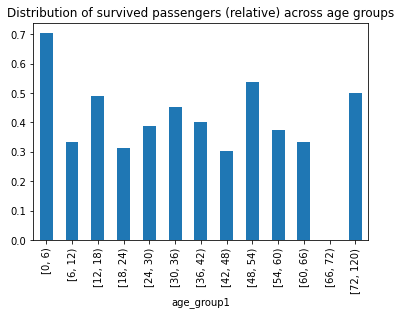

In [244]:
step_age = 6
age_list = [i for i in range(0, 73, step_age)] + [120]
data_age_dropped['age_group1'] = pd.cut(data_age_dropped.Age, age_list, right=False)
distr1 = data_age_dropped.groupby('age_group1').Survived.mean().plot.bar(title='Distribution of survived passengers (relative) across age groups')

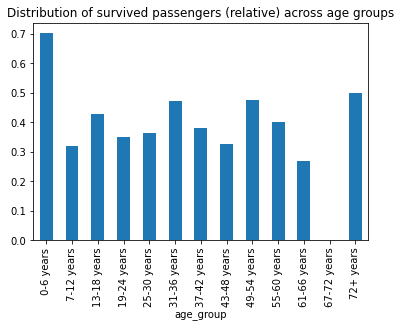

In [245]:
distr = data_age_dropped.groupby('age_group').Survived.mean().plot.bar(title='Distribution of survived passengers (relative) across age groups')

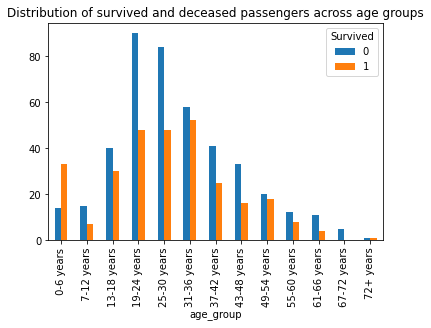

In [246]:
distr = data_age_dropped.groupby(['age_group', 'Survived']).size().unstack().plot.bar(title='Distribution of survived and deceased passengers across age groups')

< your thoughts >
Наблюдается примерно одинаковое распределение по возрасту среди выживших и погибших. Средний возраст выживших чуть ниже за счёт спасения маленьких детей и того, что почти все пассажиры старше 65 лет не спаслись. Возможно, им не дали этого сделать те, кто был помоложе.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [247]:
## your code
pclass1 = data[data.Pclass == 1].Pclass.count()
pclass2 = data[data.Pclass == 2].Pclass.count()
pclass3 = data[data.Pclass == 3].Pclass.count()
pclass1_survived = data[(data.Pclass == 1) & (data.Survived == 1)].Pclass.count()
pclass2_survived = data[(data.Pclass == 2) & (data.Survived == 1)].Pclass.count()
pclass3_survived = data[(data.Pclass == 3) & (data.Survived == 1)].Pclass.count()
print(f'From class 1 survived {pclass1_survived} persons, {pclass1_survived / pclass1 * 100} %')
print(f'From class 2 survived {pclass2_survived} persons, {pclass2_survived / pclass2 * 100} %')
print(f'From class 3 survived {pclass3_survived} persons, {pclass3_survived / pclass3 * 100} %')


From class 1 survived 136 persons, 62.96296296296296 %
From class 2 survived 87 persons, 47.28260869565217 %
From class 3 survived 119 persons, 24.236252545824847 %


<AxesSubplot:title={'center':'Passenger class influence on survival (absolute)'}, xlabel='Pclass'>

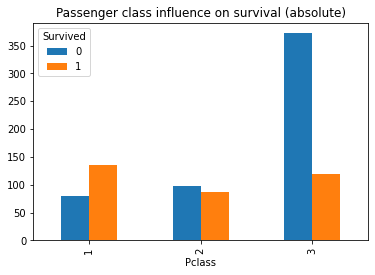

In [248]:
data.groupby(['Pclass', 'Survived']).size().unstack().plot.bar(title='Passenger class influence on survival (absolute)')

<AxesSubplot:title={'center':'Passenger class influence on survival (relative)'}, xlabel='Pclass'>

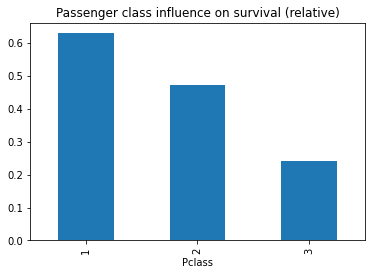

In [249]:
data.groupby(['Pclass']).Survived.mean().plot.bar(title='Passenger class influence on survival (relative)')

<AxesSubplot:title={'center':'Embarkation port survived and dead passengers (absolute)'}, xlabel='Embarked'>

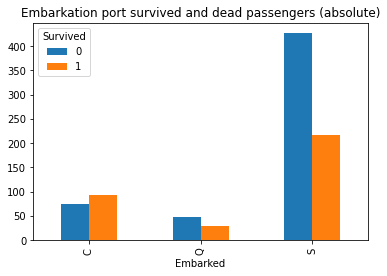

In [250]:
data.groupby(['Embarked', 'Survived']).size().unstack().plot.bar\
    (title='Embarkation port survived and dead passengers (absolute)')

<AxesSubplot:title={'center':'Embarkation port survived passengers (relative)'}, xlabel='Embarked'>

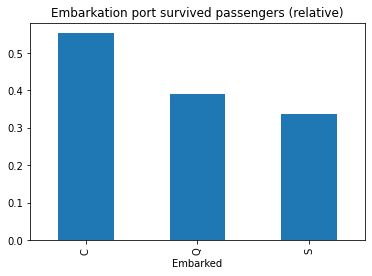

In [251]:
data.groupby(['Embarked']).Survived.mean().plot.bar(title='Embarkation port survived passengers (relative)')

In [252]:
portCherbourg = data[data.Embarked == 'C'].Embarked.count()
portQueenstown = data[data.Embarked == 'Q'].Embarked.count()
portSouthampton = data[data.Embarked == 'S'].Embarked.count()
portCherbourg_survived = data[(data.Embarked == 'C') & (data.Survived == 1)].Pclass.count()
portQueenstown_survived = data[(data.Embarked == 'Q') & (data.Survived == 1)].Pclass.count()
portSouthampton_survived = data[(data.Embarked == 'S') & (data.Survived == 1)].Pclass.count()
print(f'From Cherbourg survived {portCherbourg_survived} persons, {portCherbourg_survived / portCherbourg * 100} %')
print(f'From Queenstown survived {portQueenstown_survived} persons, {portQueenstown_survived / portQueenstown * 100} %')
print(f'From Southampton survived {portSouthampton_survived} persons, {portSouthampton_survived / portSouthampton * 100} %')

From Cherbourg survived 93 persons, 55.35714285714286 %
From Queenstown survived 30 persons, 38.961038961038966 %
From Southampton survived 217 persons, 33.69565217391305 %


<AxesSubplot:title={'center':'Summarly chart of survived passengers (relative), their embarkation port and cabin class'}, xlabel='Embarked', ylabel='Survival percentage'>

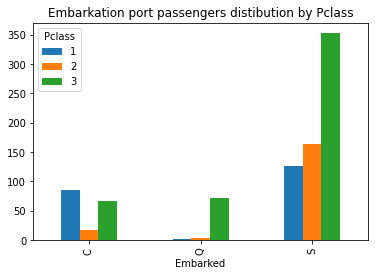

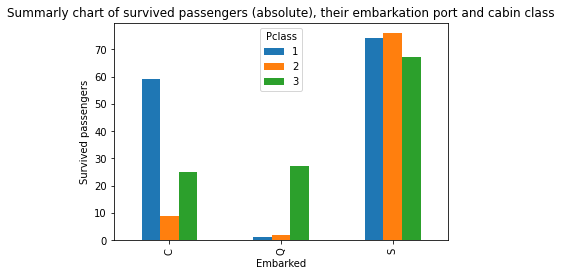

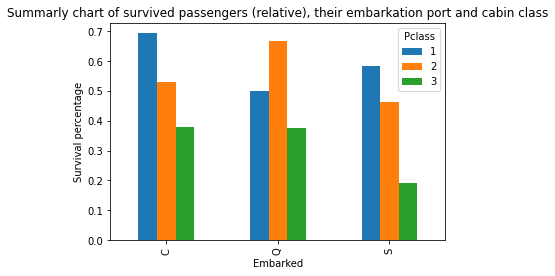

In [253]:
#port_dict = {'C': 0, 'Q': 1, 'S': 2}
#data['embark_code'] = data['Embarked'].replace(to_replace=port_dict)
data.groupby(['Embarked', 'Pclass']).size().unstack().plot.bar(title='Embarkation port passengers distibution by Pclass')
data.groupby(['Embarked', 'Pclass']).Survived.sum().unstack().plot.bar\
    (title='Summarly chart of survived passengers (absolute), their embarkation port and cabin class',  ylabel='Survived passengers')
data.groupby(['Embarked', 'Pclass']).Survived.mean().unstack().plot.bar\
    (title='Summarly chart of survived passengers (relative), their embarkation port and cabin class', ylabel='Survival percentage')

< your thoughts >
Итак, первый класс оказался самым безопасным. На первый взгляд кажется, что процент выживших зависит от порта посадки, но на самом деле, в них просто было разное распределение по классам кабин (в Шербуре больше плыло первым классом).

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [254]:
## your code
from tabulate import tabulate

print(tabulate(
    sorted(list(zip(data.columns, data.isnull().sum(), data.isnull().sum() / data.shape[0] * 100)), key=lambda x: -x[2])[:], 
    headers=['col_name', 'null_cnt', 'null_perc']))
    

col_name      null_cnt    null_perc
----------  ----------  -----------
Cabin              687    77.1044
Age                177    19.8653
Embarked             2     0.224467
Survived             0     0
Pclass               0     0
Name                 0     0
Sex                  0     0
SibSp                0     0
Parch                0     0
Ticket               0     0
Fare                 0     0


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >
На отсутствующие значения номера кабины и порта можно не обращать внимания, поскольку они не влияют на результат.
Строки, где отсутствует значение возраста, можно было бы отбросить, но это будет довольно большое количество отбрасываемой информации. Можно заполнить пробелы в возрасте средними значениями (преимущества: быстро и просто, недостатки: по сути, случайные значения) или более сложным методом, который будет учитывать структуру данных. Попробуем заполнить отсутствующие данные о возрасте методом KNN-Imputation.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [255]:
y = data['Survived']
data = pd.get_dummies(data, columns=['Sex'])
data.loc[:, 'Age_filled_mean'] = data.Age
data.Age_filled_mean = data.Age_filled_mean.fillna(data.Age_filled_mean.mean())


In [256]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
Age_feat = ['Age', 'Pclass', 'Sex_female', 'Sex_male']
X = data[Age_feat]
imputer.fit(X)
Xtrans = imputer.transform(X)
Xtrans_df = pd.DataFrame(Xtrans, index=data.index, columns=Age_feat)
data['Age_filled_knn'] = Xtrans_df.Age


In [257]:
#Используем скейлинг
scaler = StandardScaler()
data['Age_filled_mean'] = scaler.fit_transform(data[['Age_filled_mean']])
data['Age_filled_knn'] = scaler.fit_transform(data[['Age_filled_knn']])

In [258]:
#используем следующий набор признаков:
features_mean_age = ['Age_filled_mean', 'Pclass', 'Sex_female', 'Sex_male']
features_knn_age = ['Age_filled_knn', 'Pclass', 'Sex_female', 'Sex_male']
X_age_mean = data[features_mean_age]
X_age_knn = data[features_knn_age]

In [259]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logreg_model = LogisticRegression(solver='liblinear', penalty='l2')
knn_model = KNeighborsClassifier(n_neighbors = 5)


In [260]:
X_train, X_test, y_train, y_test = train_test_split(X_age_mean, y, test_size=0.2, random_state=42)

print('Logistic regression results: {:f}'.format(cross_val_score(logreg_model, X_train, y_train, 
                      scoring='accuracy', cv=5).mean()))
print('KNN results: {:f}'.format(cross_val_score(knn_model, X_train, y_train, 
                      scoring='accuracy', cv=5).mean()))

Logistic regression results: 0.794878
KNN results: 0.770984


In [261]:
X_train, X_test, y_train, y_test = train_test_split(X_age_knn, y, test_size=0.2, random_state=42)

print('Logistic regression results: {:f}'.format(cross_val_score(logreg_model, X_train, y_train, 
                      scoring='accuracy', cv=5).mean()))
print('KNN results: {:f}'.format(cross_val_score(knn_model, X_train, y_train, 
                      scoring='accuracy', cv=5).mean()))

Logistic regression results: 0.792081
KNN results: 0.790643


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [ ]:
#Kaggle - https://www.kaggle.com/alexanderpavlovets

In [262]:
## your code
data = pd.get_dummies(data, columns=['Pclass'])
features = ['Age_filled_mean', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male']
X = data[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Logistic regression results: {:f}'.format(cross_val_score(logreg_model, X_train, y_train, 
                      scoring='accuracy', cv=5).mean()))
print('KNN results: {:f}'.format(cross_val_score(knn_model, X_train, y_train, 
                      scoring='accuracy', cv=5).mean()))

Logistic regression results: 0.793470
KNN results: 0.779425


In [263]:
from sklearn.model_selection import GridSearchCV
#lr_param_grid = {'C': [0.01, 0.1, 1.0, 10.0],
#                 'penalty': ['l1', 'l2']}
#lr_clf = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000, solver='saga', n_jobs=-1), lr_param_grid)


In [264]:
import logging

In [265]:
#logging.basicConfig()
#logging.getLogger().setLevel(logging.INFO)

In [266]:
from sklearn import metrics
def fit_plot_confusion(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)

    mean, std = clf.cv_results_['mean_test_score'][clf.best_index_], \
                clf.cv_results_['std_test_score'][clf.best_index_]

    logging.info(clf.best_params_)

    disp = metrics.plot_confusion_matrix(clf, X_test, y_test % 2, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return clf.best_estimator_, {"mean": mean, "std": std}

In [267]:
#lr_best_clf, lr_stats = fit_plot_confusion(lr_clf, X_train, y_train, X_test, y_test)

In [268]:
#lr_best_clf.fit(X, y)
#y_pred = lr_best_clf.predict(X_test)
#metrics.accuracy_score(y_pred, y_test)

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.79 \leq score < 0.81,$$
$$ f(score) = 1.0, \ \ 0.81 \leq score < 0.83,$$ 
$$ f(score) = 2.5, \ \ 0.83 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [270]:
## your code
logreg_model.fit(X_age_mean, y)
#logreg_model.fit(X, y)
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

test_data = pd.get_dummies(test_data, columns=['Sex'])
#test_data = pd.get_dummies(test_data, columns=['Pclass'])

test_data.loc[:, 'Age_filled_mean'] = test_data.Age
test_data.Age_filled_mean = test_data.Age_filled_mean.fillna(test_data.Age_filled_mean.mean())

test_data['Age_filled_mean'] = scaler.fit_transform(test_data[['Age_filled_mean']])

#X_test = test_data[features]
X_test = test_data[features_mean_age]
#lr_best_clf.fit(X, y)
test_preds = logreg_model.predict(X_test)
#test_preds_tuned = lr_best_clf.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.index, 'Survived': test_preds})
output.to_csv('submission_titanic.csv', index=False)

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [ ]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [ ]:
insurance_data.head()

Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [ ]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [ ]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [ ]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

In [ ]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [ ]:
insurance_data.describe()

As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

In [ ]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [ ]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [ ]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [ ]:
gini_normalized(y_valid, y_pred)

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [ ]:
## your code